In [45]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import (
    AutoImageProcessor,
    AutoModelForDepthEstimation,
    TrainingArguments,
    Trainer
)
import numpy as np
from PIL import Image as pil_img
from pathlib import Path
import wandb
from tqdm import tqdm
import matplotlib.pyplot as plt

print("All packages are successfully imported")

All packages are successfully imported


In [ ]:
# class LunarDepthDataset(Dataset):
#     def __init__(self, image_dir, depth_dir, image_processor, split='train', is_normalized=False):
#         """
#         Args:
#             image_dir (str): Directory with RGB images
#             depth_dir (str): Directory with depth maps
#             image_processor: HuggingFace image processor
#             split (str): 'train' or 'val'
#             is_normalized (bool): Whether the depth maps are already normalized
#         """
#         self.is_normalized = is_normalized
#         print(f"\nInitializing dataset with:")
#         print(f"Image directory: {image_dir}")
#         print(f"Depth directory: {depth_dir}")
        
#         # Check if directories exist
#         if not os.path.exists(image_dir):
#             raise ValueError(f"Image directory does not exist: {image_dir}")
#         if not os.path.exists(depth_dir):
#             raise ValueError(f"Depth directory does not exist: {depth_dir}")
#         self.image_dir = Path(image_dir)
#         self.depth_dir = Path(depth_dir)
#         self.image_processor = image_processor
        
#         # Get all image files and their corresponding depth maps
#         self.image_files = sorted(list(self.image_dir.glob('*.png')))
        
#         # Split dataset
#         if split == 'train':
#             self.image_files = self.image_files[:int(0.9*len(self.image_files))]
#         else:
#             self.image_files = self.image_files[int(0.9*len(self.image_files)):]

#     def __len__(self):
#         return len(self.image_files)

#     def read_pfm(self, file_path):
#         """
#         Read a PFM file into a numpy array.
        
#         Args:
#             file_path: Path to the PFM file
            
#         Returns:
#             data: numpy array of shape (h, w) with the depth values
#             scale: float scale factor to convert to actual depth
#         """
#         with open(file_path, 'rb') as file:
#             # Read header
#             header = file.readline().decode('utf-8').strip()
#             if header != 'Pf':
#                 raise ValueError('Not a valid PFM file')
                
#             # Read dimensions
#             dims = file.readline().decode('utf-8').strip()
#             width, height = map(int, dims.split())
            
#             # Read scale factor
#             scale = float(file.readline().decode('utf-8').strip())
#             endian = '<' if scale < 0 else '>'
#             scale = abs(scale)
            
#             # Read data
#             data = np.fromfile(file, endian + 'f')
#             data = data.reshape(height, width)
            
#             return data, scale

#     def __getitem__(self, idx):
#         # Load image
#         image_path = self.image_files[idx]
#         # Change extension from .png to .pfm for depth file
#         depth_path = self.depth_dir / f"{image_path.stem}.pfm"
        
#         # Load RGB image
#         image = Image.open(image_path).convert('RGB')
        
#         # Load PFM depth map
#         depth_data, scale = self.read_pfm(str(depth_path))
        
#         # Process image
#         inputs = self.image_processor(images=image, return_tensors="pt")
#         pixel_values = inputs.pixel_values.squeeze(0)
        
#         # Process depth map
#         # Convert to tensor and handle NaN/Inf values
#         depth = torch.from_numpy(depth_data).float()
#         depth = torch.nan_to_num(depth, nan=0.0, posinf=0.0, neginf=0.0)
        
#         # Normalize depth values to [0,1] range
#         if not self.is_normalized:
#             depth_min = depth[depth > 0].min()
#             depth_max = depth.max()
#             depth = (depth - depth_min) / (depth_max - depth_min)
#             depth = torch.clip(depth, 0, 1)
        
#         return {
#             "pixel_values": pixel_values,
#             "labels": depth
#         }

In [79]:
class LunarDepthDataset(Dataset):
    def __init__(self, image_dir, depth_dir, image_processor, split='train', size=(518, 518)):
        self.image_dir = Path(image_dir)
        self.depth_dir = Path(depth_dir)
        self.image_processor = image_processor
        self.size = size
        
        # Get all image files
        self.image_files = sorted(list(self.image_dir.glob('*.png')))
        
        # Split dataset
        if split == 'train':
            self.image_files = self.image_files[:int(0.9*len(self.image_files))]
        else:
            self.image_files = self.image_files[int(0.9*len(self.image_files)):]

    def read_pfm(self, file_path):
        with open(file_path, 'rb') as file:
            header = file.readline().decode('utf-8').strip()
            if header != 'Pf':
                raise ValueError('Not a valid PFM file')
            dims = file.readline().decode('utf-8').strip()
            width, height = map(int, dims.split())
            scale = float(file.readline().decode('utf-8').strip())
            endian = '<' if scale < 0 else '>'
            scale = abs(scale)
            data = np.fromfile(file, endian + 'f')
            data = data.reshape(height, width)
            return data, scale

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        depth_path = self.depth_dir / f"{image_path.stem}.pfm"
        
        # Load image using the image processor
        image = Image.open(image_path).convert('RGB')
        pixel_values = self.image_processor(image, return_tensors="pt").pixel_values.squeeze(0)
        
        # Load and process depth map
        depth_data, scale = self.read_pfm(str(depth_path))
        depth = torch.from_numpy(depth_data).float()
        
        # Handle invalid depth values
        depth = torch.nan_to_num(depth, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Normalize depth values
        depth_min = depth[depth > 0].min()
        depth_max = depth.max()
        depth = (depth - depth_min) / (depth_max - depth_min)
        
        # Resize depth using interpolate for better memory layout
        depth = torch.nn.functional.interpolate(
            depth.unsqueeze(0).unsqueeze(0),
            size=self.size,
            mode='bilinear',
            align_corners=False
        ).squeeze(0).squeeze(0)
        
        # Create valid mask and ensure it's contiguous
        valid_mask = (depth > 0).float().contiguous()
        
        return {
            "pixel_values": pixel_values,
            "labels": depth.squeeze(0),
            "valid_mask": valid_mask.squeeze(0)
        }

    def __len__(self):
        return len(self.image_files)

In [ ]:
# class DepthEstimationTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
#         """
#         Compute the training loss for the model.
        
#         Args:
#             model: The model to train
#             inputs: The inputs to the model
#             return_outputs: Whether to return the model outputs along with the loss
#             num_items_in_batch: Number of items in the current batch (optional)
#         """
#         pixel_values = inputs["pixel_values"]
#         labels = inputs["labels"]

#         outputs = model(pixel_values=pixel_values, labels=labels)
#         loss = outputs.loss

#         return (loss, outputs) if return_outputs else loss

In [76]:
class DepthEstimationTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Custom loss computation that doesn't rely on the model's built-in training.
        """
        pixel_values = inputs["pixel_values"]
        labels = inputs["labels"]
        valid_mask = inputs.get("valid_mask", torch.ones_like(labels))

        # Forward pass without using labels
        outputs = model(pixel_values=pixel_values)
        predicted_depth = outputs.predicted_depth
        
        # Print shapes for debugging
        print(f"Predicted depth shape: {predicted_depth.shape}")
        print(f"Labels shape: {labels.shape}")
        
        # Ensure predicted_depth and labels have the same shape
        if predicted_depth.shape != labels.shape:
            # Make sure tensors are contiguous and properly reshaped
            predicted_depth = predicted_depth.contiguous()
            labels = labels.contiguous()
            
            # Use interpolate instead of Resize for better memory layout
            predicted_depth = torch.nn.functional.interpolate(
                predicted_depth.unsqueeze(1),
                size=labels.shape,
                mode='bilinear',
                align_corners=False
            ).squeeze(1)
        
        # Scale predictions to match ground truth
        mask = valid_mask > 0
        if mask.sum() > 0:
            scale = torch.median(labels[mask]) / torch.median(predicted_depth[mask])
            predicted_depth = scale * predicted_depth

        # Calculate L1 loss only on valid pixels
        l1_loss = nn.L1Loss(reduction='none')(predicted_depth, labels) * valid_mask
        l1_loss = torch.sum(l1_loss) / (torch.sum(valid_mask) + 1e-8)

        # Add relative depth loss (optional)
        relative_loss = 0
        if mask.sum() > 0:
            rel_diff = torch.abs(torch.log(predicted_depth[mask] + 1e-8) - torch.log(labels[mask] + 1e-8))
            relative_loss = torch.mean(rel_diff)

        loss = l1_loss + 0.5 * relative_loss

        if return_outputs:
            return loss, outputs
        return loss


In [ ]:
# def train_lunar_depth_model(
#     train_image_dir,
#     train_depth_dir,
#     output_dir,
#     model_name="LiheYoung/depth-anything-small-hf",
#     num_epochs=10,
#     batch_size=8,
#     learning_rate=2e-5,
# ):
#     """
#     Fine-tune Depth Anything model on lunar surface data.
#     """
#     # Initialize wandb
#     wandb.init(project="lunar-depth-estimation")
    
#     # Load model and image processor
#     image_processor = AutoImageProcessor.from_pretrained(model_name)
#     model = AutoModelForDepthEstimation.from_pretrained(
#         model_name,
#         torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
#     )
    
#     # Prepare datasets
#     train_dataset = LunarDepthDataset(
#         train_image_dir,
#         train_depth_dir,
#         image_processor,
#         split='train'
#     )
#     val_dataset = LunarDepthDataset(
#         train_image_dir,
#         train_depth_dir,
#         image_processor,
#         split='val'
#     )
    
#     # Define training arguments
#     training_args = TrainingArguments(
#         output_dir=output_dir,
#         num_train_epochs=num_epochs,
#         per_device_train_batch_size=batch_size,
#         per_device_eval_batch_size=batch_size,
#         learning_rate=learning_rate,
#         weight_decay=0.01,
#         logging_dir=f"{output_dir}/logs",
#         logging_steps=10,
#         evaluation_strategy="epoch",
#         save_strategy="epoch",
#         load_best_model_at_end=True,
#         report_to="wandb",
#         fp16=torch.cuda.is_available(),
#     )
    
#     # Initialize trainer
#     trainer = DepthEstimationTrainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_dataset,
#         eval_dataset=val_dataset,
#     )
    
#     # Train the model
#     trainer.train()
    
#     # Save the final model
#     trainer.save_model(f"{output_dir}/final_model")
    
#     # Close wandb
#     wandb.finish()

In [78]:
def train_lunar_depth_model(
    train_image_dir,
    train_depth_dir,
    output_dir,
    model_name="LiheYoung/depth-anything-small-hf",
    num_epochs=10,
    batch_size=8,
    learning_rate=2e-5,
):
    # Initialize wandb
    wandb.init(project="lunar-depth-estimation")
    
    # Load model and image processor
    image_processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModelForDepthEstimation.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
    )
    
    # Prepare datasets
    train_dataset = LunarDepthDataset(
        train_image_dir,
        train_depth_dir,
        image_processor,
        split='train'
    )
    val_dataset = LunarDepthDataset(
        train_image_dir,
        train_depth_dir,
        image_processor,
        split='val'
    )
    
    # Define training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        weight_decay=0.01,
        logging_dir=f"{output_dir}/logs",
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        report_to="wandb",
        fp16=torch.cuda.is_available(),
    )
    
    # Initialize trainer
    trainer = DepthEstimationTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )
    
    # Train the model
    trainer.train()
    
    # Save the final model
    trainer.save_model(f"{output_dir}/final_model")
    
    # Close wandb
    wandb.finish()
   

In [51]:
def evaluate_model(model, image_processor, test_image_dir, test_depth_dir):
    """
    Evaluate the model using standard depth estimation metrics.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    metrics = {
        'abs_rel': [],
        'rmse': [],
        'delta1': []  # Threshold 1.25
    }
    
    test_dataset = LunarDepthDataset(test_image_dir, test_depth_dir, image_processor, split='val')
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(pixel_values=pixel_values)
            pred_depth = outputs.predicted_depth
            
            # Calculate metrics
            abs_rel = torch.mean(torch.abs(pred_depth - labels) / labels)
            rmse = torch.sqrt(torch.mean((pred_depth - labels) ** 2))
            delta = torch.max(pred_depth / labels, labels / pred_depth)
            delta1 = (delta < 1.25).float().mean()
            
            metrics['abs_rel'].append(abs_rel.item())
            metrics['rmse'].append(rmse.item())
            metrics['delta1'].append(delta1.item())
    
    # Average metrics
    for k in metrics:
        metrics[k] = np.mean(metrics[k])
    
    return metrics

In [52]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: False


In [53]:
# Define Training Image/Depth Directories
train_image_dir = "/Users/brianwu/Documents/Projects/Stanford/lunar_autonomy_challenge/LuSNAR/Moon_1/image0/color/"
train_depth_dir = "/Users/brianwu/Documents/Projects/Stanford/lunar_autonomy_challenge/LuSNAR/Moon_1/image0/depth/"
output_dir = "/Users/brianwu/Desktop"

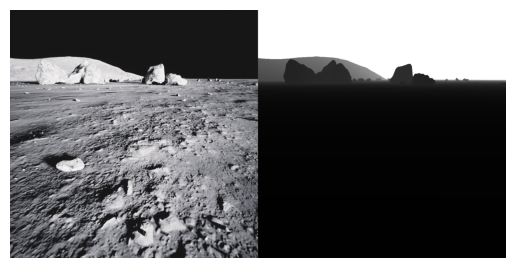

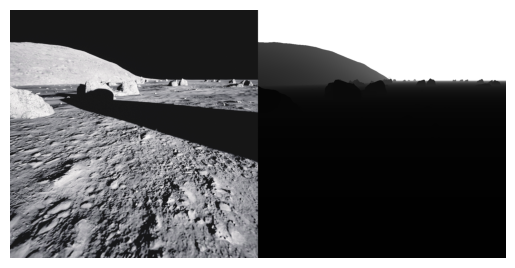

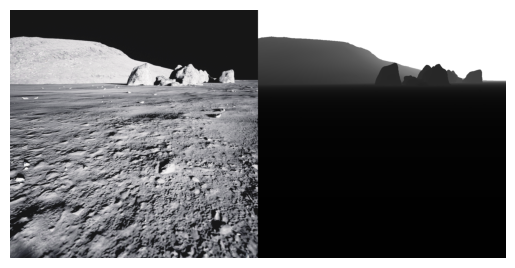

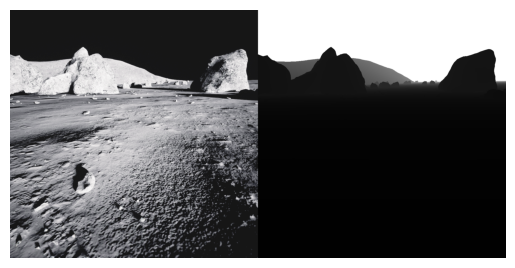

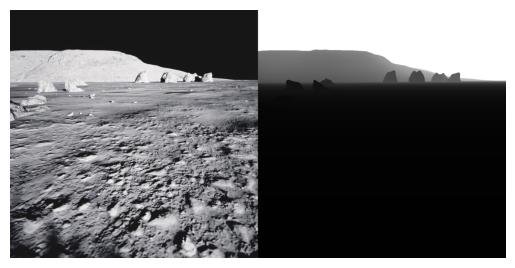

In [54]:
"""
Show first 5 images and depth maps
"""
def get_concat_h(im1, im2):
    dst = pil_img.new('RGB', (im1.width + im2.width, max(im1.height, im2.height)))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

for i in range(len(os.listdir(train_image_dir)[:5])):
    image_path = os.path.join(train_image_dir, os.listdir(train_image_dir)[i])
    depth_path = os.path.join(train_depth_dir, os.listdir(train_image_dir)[i].split('.')[0] + '.pfm')
    
    image = pil_img.open(image_path)
    depth_map = pil_img.open(depth_path)
    depth_map = depth_map.transpose(Image.FLIP_TOP_BOTTOM)
    
    # Convert depth map to RGB if depth map grayscale
    if depth_map.mode != 'RGB':
        depth_map = depth_map.convert('RGB')

    # Ensure both images have the same height
    if image.height != depth_map.height:
        depth_map = depth_map.resize((depth_map.width, image.height))

    # Concatenate images horizontally
    combined_image = get_concat_h(image, depth_map)

    # Display the combined image
    plt.imshow(np.array(combined_image))
    plt.axis('off')
    plt.show()

In [55]:
from transformers import AutoImageProcessor
output_dir = "/Users/brianwu/Desktop"

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
test_dataset = LunarDepthDataset(
    image_dir=train_image_dir,
    depth_dir=train_depth_dir,
    image_processor=image_processor,
    split='train'
)
print(f"Dataset size: {len(test_dataset)}")

# Test loading one sample
sample = test_dataset[0]
print("Sample keys:", sample.keys())
print("Image shape:", sample["pixel_values"].shape)
print("Depth shape:", sample["labels"].shape)

Dataset size: 984
Sample keys: dict_keys(['pixel_values', 'labels', 'valid_mask'])
Image shape: torch.Size([3, 518, 518])
Depth shape: torch.Size([518, 518])


In [56]:
def visualize_samples(dataset, num_samples=3, figsize=(15, 5)):
    """
    Visualize random samples from the lunar depth dataset.
    Args:
        dataset: LunarDepthDataset instance
        num_samples: Number of samples to visualize
        figsize: Figure size for the plot
    """
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, num_samples, figsize=figsize)
    
    for idx, sample_idx in enumerate(indices):
        sample = dataset[sample_idx]
        
        # Convert the normalized tensor back to image format
        image = sample["pixel_values"].permute(1, 2, 0).numpy()
        depth = sample["labels"].numpy()
        
        # Plot RGB image
        axes[0, idx].imshow(image)
        axes[0, idx].axis('off')
        axes[0, idx].set_title(f'RGB Image {sample_idx}')
        
        # Plot depth map
        depth_plot = axes[1, idx].imshow(depth, cmap='plasma')
        axes[1, idx].axis('off')
        axes[1, idx].set_title(f'Depth Map {sample_idx}')
        
        # Add colorbar
        plt.colorbar(depth_plot, ax=axes[1, idx])
    
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..2.5179958].


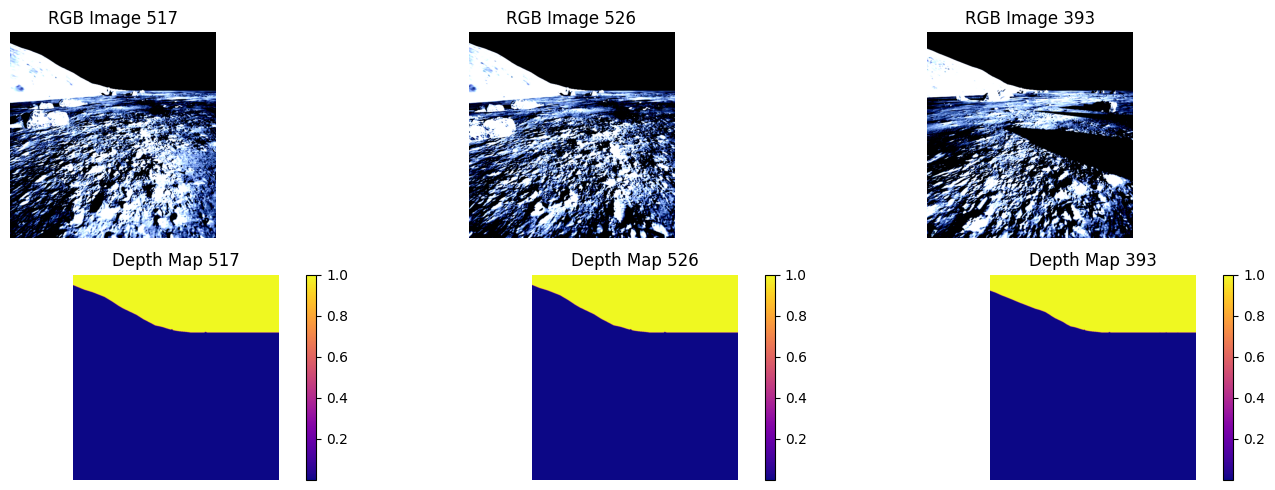

In [58]:
visualize_samples(test_dataset, num_samples=3)

In [43]:
try:
    # Train the model
    train_lunar_depth_model(
        train_image_dir=train_image_dir,
        train_depth_dir=train_depth_dir,
        output_dir=output_dir,
        num_epochs=10,
        batch_size=8,
        learning_rate=2e-5
    )
    
    # Load and evaluate
    model = AutoModelForDepthEstimation.from_pretrained(f"{output_dir}/final_model")
    image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
    
    metrics = evaluate_model(
        model,
        image_processor,
        train_image_dir,
        train_depth_dir
    )
    
    print("\nEvaluation Metrics:")
    print(f"Absolute Relative Error: {metrics['abs_rel']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"δ1 (% within 1.25): {metrics['delta1']*100:.2f}%")
    
except Exception as e:
    print(f"Error occurred: {str(e)}")
    import traceback
    traceback.print_exc()


Initializing dataset with:
Image directory: /Users/brianwu/Documents/Projects/Stanford/lunar_autonomy_challenge/LuSNAR/Moon_1/image0/color/
Depth directory: /Users/brianwu/Documents/Projects/Stanford/lunar_autonomy_challenge/LuSNAR/Moon_1/image0/depth/

Initializing dataset with:
Image directory: /Users/brianwu/Documents/Projects/Stanford/lunar_autonomy_challenge/LuSNAR/Moon_1/image0/color/
Depth directory: /Users/brianwu/Documents/Projects/Stanford/lunar_autonomy_challenge/LuSNAR/Moon_1/image0/depth/


/Users/brianwu/miniforge3/envs/Stanford-LAC/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Error occurred: Training is not implemented yet


Traceback (most recent call last):
  File "/var/folders/mk/2gj1khx94wlfpyn39bq4mwbr0000gn/T/ipykernel_49662/2115778092.py", line 3, in <module>
    train_lunar_depth_model(
  File "/var/folders/mk/2gj1khx94wlfpyn39bq4mwbr0000gn/T/ipykernel_49662/1195766784.py", line 63, in train_lunar_depth_model
    trainer.train()
  File "/Users/brianwu/miniforge3/envs/Stanford-LAC/lib/python3.10/site-packages/transformers/trainer.py", line 2171, in train
    return inner_training_loop(
  File "/Users/brianwu/miniforge3/envs/Stanford-LAC/lib/python3.10/site-packages/transformers/trainer.py", line 2531, in _inner_training_loop
    tr_loss_step = self.training_step(model, inputs, num_items_in_batch)
  File "/Users/brianwu/miniforge3/envs/Stanford-LAC/lib/python3.10/site-packages/transformers/trainer.py", line 3675, in training_step
    loss = self.compute_loss(model, inputs, num_items_in_batch=num_items_in_batch)
  File "/var/folders/mk/2gj1khx94wlfpyn39bq4mwbr0000gn/T/ipykernel_49662/1412451435.py", l

In [80]:
# Set your paths
train_image_dir = "/Users/brianwu/Documents/Projects/Stanford/lunar_autonomy_challenge/LuSNAR/Moon_1/image0/color/"
train_depth_dir = "/Users/brianwu/Documents/Projects/Stanford/lunar_autonomy_challenge/LuSNAR/Moon_1/image0/depth/"
output_dir = "/Users/brianwu/Desktop"

# Train the model
train_lunar_depth_model(
    train_image_dir=train_image_dir,
    train_depth_dir=train_depth_dir,
    output_dir=output_dir,
    num_epochs=10,
    batch_size=8,
    learning_rate=2e-5
)

# Load and evaluate the best model
model = AutoModelForDepthEstimation.from_pretrained(f"{output_dir}/final_model")
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")

metrics = evaluate_model(
    model,
    image_processor,
    train_image_dir,  # You might want to use a separate test set
    train_depth_dir
)

print("\nEvaluation Metrics:")
print(f"Absolute Relative Error: {metrics['abs_rel']:.4f}")
print(f"RMSE: {metrics['rmse']:.4f}")
print(f"δ1 (% within 1.25): {metrics['delta1']*100:.2f}%")

/Users/brianwu/miniforge3/envs/Stanford-LAC/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Predicted depth shape: torch.Size([8, 518, 518])
Labels shape: torch.Size([8, 518, 518])


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.